# Thermal Management System

*Author: F. Pollet - 2020*

modified by *V. Palladino - 2021*
***
*CoolProp package could be used to compute thermodynamic properties of fluids*

The fuel cell cooling system maintains all components at the desired temperature level. The temperature of the fuel cell stacks must be kept at its optimal, generally in the temperature range from 75 to 85°C for low-temperature PEMFC. The compressed air must be cooled at the compressor exit and the inlet hydrogen has to be heated prior entering the anode. <br>

Because PEM fuel cells operate at low temperatures, it is much more challenging to dissipate the heat than in combustion engines. Although PEM fuel cells have a very high efficiency (45-60%), there is still a significant amount of heat generated. <br>

The figure below presents the heat flows inside a typical fuel cell system. Part of the generated heat (a few per cent) is removed from the stack by the extra air and hydrogen, while some may be used to vaporize the product water for the inlet air humidification. Natural convection from the fuel cell body removes a few additional percent of the heat. Finally, about 35% of the total energy entering the fuel cell has to be removed by the cooling system.

<img src="sankeymatic.png" alt="Drawing" style="width: 500px;"/>

The thermal management system can be divided in two parts:<br>
* The cooling module, which includes the cooling pump and the heat exchangers interfacing with the fuel cell stack and the other components of the system (compressor, hydrogen lines)
* The radiator/main heat exchanger, whose purpose is to reject the heat from the system to the ambient air or to other systems within the aircraft.
The following figures shows a typical layout of a thermal management system.

<img src="layout.png" alt="Drawing" style="width: 700px;"/>

### References

[1] P. Vratny, "Conceptual Design Methods of Electric Power Architectures for Hybrid Energy Aircraft", PhD Thesis, 2018

[2] Fefermann et al., "Hybrid-Electric Motive Power Systems for Commuter Transport Applications", 2016

[3] Inn-Balance FCH project, www.innbalance-fch-project.eu 

[4] AKG global standard coolers, https://www.akg-group.com/fileadmin/user_upload/Brochures/AKG-Line/AKG_LineA_en.pdf

[5] Mao et al., "Cooling Ability/Capacity and Exergy Penalty Analysis of Each Heat Sink of Modern Supersonic Aircraft", 2019

[6] Petukov (High Temperature I, 1963) and Schlichting (Grenzschicht-Theorie, 1958). https://www.tec-science.com/mechanics/gases-and-liquids/calculation-of-the-nusselt-numbers-for-forced-flows-over-plates-and-in-pipes/

[7] M.R. Islam, B. Shabani, G. Rosengarten, J. Andrews, "The potential of using nanofluids in PEM fuel cell cooling systems: A review", 2015

[8] Berger O. "Thermodynamische Analyse eines Brennstoffzellensystems zum Antrieb von Kraftfahrzeugen", 2009

[9] L.P. Pang, "Study on Heat Transfer Performance of Skin Heat Exchanger", 2014

In [2]:
# LIBRARIES
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rc
#rc('text', usetex=True)
from sklearn.linear_model import LinearRegression
import scipy.optimize as optimize
from scipy.optimize import minimize

# 1 - Cooling module

The mass of the cooling module (coolant, pumps, air/hydrogen heat exchangers) is calculated based on the results from the **Inn-Balance FCH project**.

| Parameter | Value| Units |
| --- | --- | ---|
| Fuel cell gross power | 100 | kW |
| Cooling module weight |17.2 | kg|
| Weight-to-power ratio | **0.172** | kg/kW |


In [2]:
FC_power = 500 # [kW]
Weight_to_power_cooling = 0.172 # [kg/kW]
Cooling_module_weight = FC_power*Weight_to_power_cooling # [kg]

print('Fuel cell max. power: ', FC_power, ' kW')
print('Cooling module weight: ', Cooling_module_weight, ' kg')

Fuel cell max. power:  500  kW
Cooling module weight:  86.0  kg


## Coolant pump power consumption

The required electric pump power is estimated based on **P. Vratny, "Conceptual Design Methods of Electric Power Architectures for Hybrid Energy Aircraft", PhD Thesis, 2018**.

First, the flow rate is derived from the heat power $P_{th}$ and the properties of the coolant, under static operating conditions:

$$ \dot{V} = \frac{P_{th} . k_s}{c_P . \rho . \Delta T}$$

The temperature difference $\Delta T$ is the difference between the mean coolant and the component temperature. To take account for uncertainties, a safety factor $k_s$ is considered.<br>
A potential candidate for the coolant is a potassium fromate/water mixture, which is non-conductive and provides a high specific heat of $3200 J/kg/K$.

The required pump power is estimated by multiplying the flow rate by the pressure loss across the pump:

$$ P_{pump} = \dot{V}.dp $$

Finally, taking account for the losses of the hydraulic pump and the electric motor, the required input power of the cooling system is:

$$ P_{cool} = \frac{dp}{\eta_{hydr} . \eta_{elec}} \frac{P_{th}}{c_P . \rho . \Delta T} . k_s $$

The assumptions for the liquid cooling system, derived from P. Vratny, are summarized below.

| Design parameter | Value | Unit |
| --- | --- | ---|
| Hydraulic pump efficiency $\eta_{hydr}$ | 0.85 | - |
| Electric motor efficiency $\eta_{elec}$ | 0.95 | - |
| Pressure loss $dp$ | 2 | bar |
| Temperature difference $\Delta T$ | 5 | °C |
| Safety factor $k_s$ | 1.2 | - |



In [44]:
# THERMODYNAMICS
P_FC = 1300e3 # FC output power [W]
V_cell  = 0.65 # Cell voltage [V]
# P_th   = P_FC*(1.25/V_cell - 1) # heat flow generated by the fuel cell stack [W]
P_th = P_FC/0.5*0.35 # heat flow to be removed by the cooling system [W]
T_FC = 80 # fuel cell temperature [°C]
T_cool = 75 # coolant temperature [°C]
deltaT = T_FC - T_cool
dp = 2e5 # pressure loss [Pa]

# COOLANT PROPERTIES
cp = 3200 # specific heat [J/kg/K]
rho = 1250 # density [kg/m3]

# EFFICIENCIES
eta_hydr = 0.85 # hydraulic pump efficiency
eta_elec = 0.95 # electric motor-controller efficiency
ks = 1.2 # safety factor

# SPECIFIC POWER COOLING SYSTEM
#rho_sys = 1200 # [W/kg]

# ELECTRIC PUMP SIZING
flow_rate = P_th*ks / (cp*rho*deltaT) # coolant liquid flow rate [m3/s]
P_pump = flow_rate*dp # pump power [W]
P_cool = P_pump / (eta_hydr*eta_elec) #  required input power of the system [W]

#m_cool = P_cool / rho_sys # mass of the cooling system [kg]
print("Heat to be rejected (kW): ", P_th/1000)
print("Coolant flow rate (L/s): ", flow_rate*1000)
print("Required input power (kW): ", P_cool/1000)

Heat to be rejected (kW):  910.0
Coolant flow rate (L/s):  54.6
Required input power (kW):  13.523219814241486


**From the results above it appears that the coolant pump requires a negligible power input in regards to the total system power.**

---------------------------

# 2a - Hydrogen cooling ability

The hydrogen consumed by the fuel cells can be used as a heat sink for the thermal management system. The liquid hydrogen is first pumped out of the tank and passes through one or several heat exchangers in the cooling system prior entering the fuel cell stacks in a gaseous state at 80°C.<br>
The cooling ability of the hydrogen is determined by its flow rate and temperature increase. The hydrogen flow rate is derived from the stacks power and the mean voltage of each cell in the stacks.

$$ Q_{H2} = \dot{m}_{H2}.L_{H2} + \dot{m}_{H2}.c_{p,H2}.\Delta T$$

$$ \dot{m}_{H2} = 1.05 \times 10^{-8} \times \frac{P_{FC}}{V_{cell}} $$

The average values of the parameters are summarized in the table below.

| Parameter |Average value | Unit|
| --- | --- | --- |
| Latent heat of hydrogen $L_{H2}$ | 455 | kJ/kg |
| Specific heat capacity of hydrogen $c_{p,H2}$ | 14.30 | kJ/kg/K |
| Unit cell voltage | 0.65 | V |

Cooling capacity of hydrogen inflow:  181.5905  kW
Percentage of required heat rejection:  12.97075  %
Cooling capacity of hydrogen inflow:  231.64049999999997  kW
Percentage of required heat rejection:  16.545749999999998  %


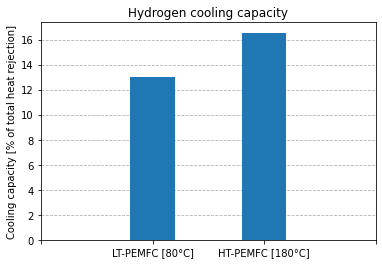

In [5]:
def hydrogen_cooling(P_fc, T_cold, T_hot):
    # Constant parameters
    L_H2 = 455 # Latent heat of vaporization [kJ/kg]
    cp_H2 = 14.3 # Specific heat capacity [kJ/kg/K]
    V_cell = 0.6 # Unit cell voltage [V]
    
    # Hydrogen flow rate
    H2_flow = 1.05e-8*P_fc/V_cell # [kg/s]
    
    # Cooling capacity
    Q_H2 = H2_flow*L_H2 + H2_flow*cp_H2*(T_hot-T_cold) # [kW]
    
    return 1000*Q_H2 # [W]

# EXAMPLE
P_fc = 2000e3 # Fuel cell system power [W]
T_cold = 22 # temperature of hydrogen leaving the tank [K]
T_hot_array = np.array([273 + 80, 273+180]) # temperature of hydrogen entering the fuel cells [K]
Q_H2_array = []

for T_hot in T_hot_array:
    Q_H2 = hydrogen_cooling(P_fc,T_cold,T_hot) # [W]
    Q_H2_array.append(Q_H2/(P_fc/0.5*0.35)*100)
    print('Cooling capacity of hydrogen inflow: ', Q_H2/1000, ' kW')
    print('Percentage of required heat rejection: ', Q_H2/(P_fc/0.5*0.35)*100, ' %')
    
fig, ax = plt.subplots()
ax.bar([1,2], Q_H2_array, width=0.4)
plt.ylabel('Cooling capacity [% of total heat rejection]')
plt.title('Hydrogen cooling capacity')
plt.xticks(np.arange(0,4), ('', 'LT-PEMFC [80°C]', 'HT-PEMFC [180°C]',''))
ax.grid(axis='y',ls='--')
ax.set_axisbelow(True)


The cooling capacity of the hydrogen inlet entering the fuel cells represents about 10% of the total amount of heat to be rejected by the system.

--------------------------

# 2b - Ram air heat exchangers (RAHX)

The heat generated by the fuel cells can be transferred from the cooling circuit to the ambient air via a radiator cooled with ram air. However, the small temperature difference between the system and the ambient air impose large radiators and ram air intakes.

The radiators (including AC-motor powered fans) weights and volumes are derived from commercial products (AKG, https://www.akg-group.com/fileadmin/user_upload/Brochures/AKG-Line/AKG_LineA_en.pdf). The sizing laws are illustrated below. 

Note that the AC-motor driven fans may not be useful when the aircraft is in flight. Indeed, NACA scoops allow air to flow directly into the radiators, with minimal or no energy required. Thus, the weight of the assembly can be considerably reduced. The weight savings are expected to be around 20\%.


### Model derived from AKG catalog

Weight law (incl. AC-motor driven fans):  5.104669855774802 + 40.28739878392453 * heat rejection
R² weight regression:  0.9925754356302485
Frontal area law (incl. AC-motor driven fans):  0.2897094985148301 + 0.21889389159131287 * heat rejection
R² frontal area regression:  0.9887083685560444


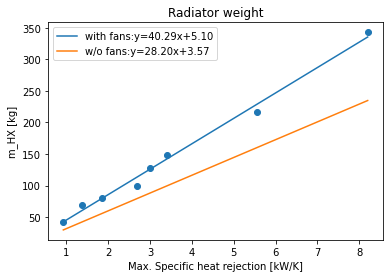

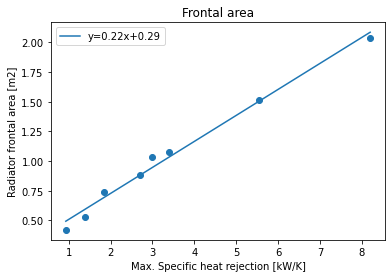

In [5]:
from scipy import stats
# AKG catalog
heat_rejection_array = np.array([0.93, 1.38, 1.85, 2.7, 3, 3.4, 5.55, 8.2]).reshape((-1, 1)) # [kW/K]
weight_array = np.array([43, 69, 81, 100, 128, 148, 217, 343])# [kg]
frontal_area_array = np.array([0.42, 0.53, 0.74, 0.88, 1.03, 1.08, 1.51, 2.04]) # [m2]

# Expected weight savings from removing AC-motor driven fans
w_ratio = 0.3 #0.2 used by felix

# Linear regressions models
weight_model_with_ACmotor = LinearRegression().fit(heat_rejection_array, weight_array)
weight_model = LinearRegression().fit(heat_rejection_array, weight_array*(1-w_ratio))
area_model = LinearRegression().fit(heat_rejection_array, frontal_area_array)

# coefficient of determination (R²) 
r2_weight = weight_model_with_ACmotor.score(heat_rejection_array, weight_array)
r2_area = area_model.score(heat_rejection_array, frontal_area_array)

print('Weight law (incl. AC-motor driven fans): ', weight_model_with_ACmotor.intercept_, '+',  weight_model_with_ACmotor.coef_[0], '* heat rejection')
print('R² weight regression: ', r2_weight)

print('Frontal area law (incl. AC-motor driven fans): ', area_model.intercept_, '+',  area_model.coef_[0], '* heat rejection')
print('R² frontal area regression: ', r2_area)
#regression part

#plt.plot(x, line, 'r', label='y={:.2f}x+{:.2f}'.format(weight_model_with_ACmotor.coef_[0],weight_model_with_ACmotor.intercept_))


plt.scatter(heat_rejection_array,weight_array)
#plt.plot(heat_rejection_array,weight_model_with_ACmotor.predict(heat_rejection_array.reshape(-1, 1)), label='incl. AC-motor driven fans')
label1='with fans:' +'y={:.2f}x+{:.2f}'.format(weight_model_with_ACmotor.coef_[0],weight_model_with_ACmotor.intercept_)

plt.plot(heat_rejection_array,weight_model_with_ACmotor.predict(heat_rejection_array.reshape(-1, 1)), label=label1)

label2='w/o fans:' +'y={:.2f}x+{:.2f}'.format(weight_model.coef_[0],weight_model.intercept_)
plt.plot(heat_rejection_array,weight_model.predict(heat_rejection_array.reshape(-1, 1)), label=label2)

#plt.plot(heat_rejection_array,weight_model.predict(heat_rejection_array.reshape(-1, 1)), label='Estimated w/o AC-motor driven fans')
plt.legend()
plt.title('Radiator weight')
plt.xlabel('Max. Specific heat rejection [kW/K]')
plt.ylabel('m_HX [kg]')
plt.show()

plt.scatter(heat_rejection_array,frontal_area_array)
#plt.plot(heat_rejection_array,area_model.predict(heat_rejection_array.reshape(-1, 1)), label='radiator frontal area')
label3='y={:.2f}x+{:.2f}'.format(area_model.coef_[0],area_model.intercept_)

plt.plot(heat_rejection_array,area_model.predict(heat_rejection_array.reshape(-1, 1)), label=label3)

plt.legend()
plt.title('Frontal area')
plt.xlabel('Max. Specific heat rejection [kW/K]')
plt.ylabel('Radiator frontal area [m2]')
plt.show()

# save the model to disk
#import pickle
#filename = 'Radiator_weight_model.sav'
#pickle.dump(weight_model, open(filename, 'wb'))
#filename = 'Radiator_area_model.sav'
#pickle.dump(area_model, open(filename, 'wb'))

### Radiator sizing

The inlet coolant temperature is supposed to be kept at a constant value of 75°C. In addition, the total temperature of the cooling airflow is determined by the flight conditions.

The model also takes as input the number of radiators used to reject the heat, from one single large radiator to several smaller radiators. However, the configuration of the radiators (series or parallel) is not considered in this preliminary study.

In [52]:
def radiator_sizing(Q_req, Altitude, Mach, Disa, T_load, weight_model, area_model, N):
    # Thermo/aero parameters
    T_inf = 288.15 - 0.0065 * Altitude + Disa # Ambient air temperature [K]
    T_tot = T_inf * (1 + 0.2 * Mach * Mach) #0.2=(gamma-1)/2
    delta_T = T_load - T_tot # [K]
    print('specific_heat_rejection', Q_req/1000/N/delta_T)
    # Weight and frontal area predictions
    unit_weight = weight_model.predict(np.array(Q_req/1000/N/delta_T).reshape(-1, 1))
    total_weight = N * unit_weight
    unit_area = area_model.predict(np.array(Q_req/1000/N/delta_T).reshape(-1, 1))
    total_area = N * unit_area
    
    return unit_weight[0], total_weight[0], unit_area[0], total_area[0]

# EXAMPLE 
Q_req = 270e3 # Heat rejection requirement [W]
Altitude = 0 # [m]
Mach = 0.2 # [-]
Disa = 0 # Delta ISA [K]
T_load = 273.15 + 75 # Coolant temperature [K]
N =1# number of radiators [-]

unit_weight, total_weight, unit_area, total_area = radiator_sizing(Q_req, Altitude, Mach, Disa, T_load, weight_model, area_model, N)
print('Radiator weight (unit/total): ', unit_weight, ' / ', total_weight, ' kg')
print('Radiator frontal area (unit/total): ', unit_area, ' / ', total_area, ' m2')

specific_heat_rejection 4.679797832733627
Radiator weight (unit/total):  135.54908595988212  /  135.54908595988212  kg
Radiator frontal area (unit/total):  1.3140886579824855  /  1.3140886579824855  m2


### Drag penalty
*Derived from Yu-Feng Mao, "Cooling Ability/Capacity and Exergy Penalty Analysis of Each Heat Sink of Modern Supersonic Aircraft", 2019.*


The drag penalty caused by the liquid/air heat exchangers can be determined by the momentum loss of the Ram Air (RA) flow:

$$ D_{RA} = \dot{m_{RA}} . V_{RA} . \zeta _{RA} $$

where $\zeta_{RA}$ is the velocity loss coefficient. <br>
The mass flow rate $\dot{m_{RA}}$ is directly determined by the heat rejection $Q$, temperature difference $\Delta T$, and the heat transfer efficiency $\eta$ of the radiator.

$$ \dot{m_{RA}} = \frac{Q}{c_{p,air} . \eta . (T_{coolant} - T_{tot,RA})} $$

Finally, the drag coefficient $C_x$ and exergy penalty related to the internal drag caused by the radiator are determined as follows:

$$ C_x = \frac{2 D_{RA}}{\rho_{air} . V_{RA}^2 . S_{ref}} $$

$$ Ex = D_{RA} . V_{RA} $$

**Assumptions:** <br>
* The external drag caused by the ram air intake is not considered in this study. 
* The duct geometry effects on the air flow is not taken into account: $V_{RA} = V_{TAS}$ and $T_{tot,RA} = T_{tot,fuselage}$
* The radiator efficiency $\eta$ is considered constant, although in reality it varies with the air flow rate

The radiator parameters for the estimating model are summarized in the table below.

| Design parameter | Value |
| --- | --- |
| Radiator Heat transfer efficiency | $\eta$ = 0.8|
| Velocity loss coefficient | $\zeta_{RA}$ = 0.2 |
| Specific heat capacity of air | $c_{p,air}$ = 1004 J/K/kg| 

-------------------------

The ATR-72 parasite drag counts data may be used as a basis of comparison:

|Calculation conditions|  |
| --- | --- |
| Mach | 0.4 |
| Altitude | 20000 ft|
| Sref | 61 m$^2$|

| Overall drag (induced + parasitic) | $10^4$ Cd |
| --- | --- |
| **Total aircraft** | **480** |

Air intake:  38.28602973236822  kg/s
NACA cross section:  0.5254755537658665  m2
Drag penalty:  561.8330559833022  N
Drag counts:  34.45741336169616 * 10^4 Cx
Aircraft Cd increase:  7.178627783686699 %


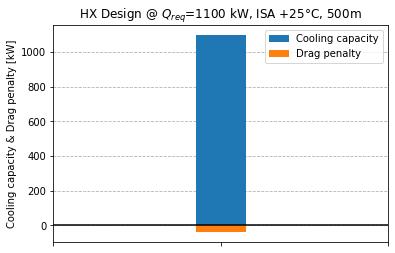

In [7]:
def drag_RA(Q_req, Altitude, Mach, Disa, T_load):
    # Radiators parameters
    eta_RA = 0.8 # radiator efficiency [-]
    xsi_RA = 0.2 # velocity loss coefficient [-]
    
     # Thermo/aero parameters
    T_inf = 288.15 - 0.0065 * Altitude + Disa # Air Static temperature [K]
    T_tot = T_inf * (1 + 0.2 * Mach * Mach) # Air Total temperature
    P_inf = 101325 * (1 - (Altitude / 44330.78)) ** 5.25587611 # Static pressure [K]
    V_sound = 20.047 * np.sqrt(T_inf + Disa) # sound velocity [m/s]
    V_tas = Mach*V_sound # True airspeed [m/s]
    cp_air = 1004 # Specific heat capacity [J/K/kg]
    rho_air = 0.0034837 * P_inf / (Disa + T_inf) # air density [kg/m3]
    S_ref = 61 # ATR-72 reference surface [m2]

    # Air intake required
    airflow = Q_req / (cp_air*eta_RA*(T_load-T_tot)) # [kg/s]
    A_req = airflow/(rho_air*V_tas)

    # Drag penalty
    D_RA = airflow * V_tas * xsi_RA # [N]
    Cx = 2*D_RA/(rho_air*V_tas**2*S_ref) # [-]
    
    # Exergy penalty
    Exergy = D_RA * V_tas # [W]
    
    return airflow, D_RA, Cx, Exergy, A_req

# EXAMPLE
Q_req    = 1100e3 # Heat rejection requirement [W]
Altitude = 500 # [m]
Mach = 0.2 # [-]
Disa = 25 # Delta ISA [K]
T_load = 273.15 + 75 # Coolant temperature [K]
airflow, D_RA, Cx, Exergy, A_req = drag_RA(Q_req, Altitude, Mach, Disa, T_load)
print('Air intake: ', airflow, ' kg/s')
print('NACA cross section: ', A_req, ' m2')
print('Drag penalty: ', D_RA, ' N')
print('Drag counts: ', Cx*1e4, '* 10^4 Cx')
print('Aircraft Cd increase: ', 100*Cx*1e4/480, '%')
#print('Exergy penalty from drag: ', Exergy/1000, ' kW')
#print('Cooling-penalty ratio: ', Q_req/Exergy)

fig, ax = plt.subplots()
ax.bar(1, Q_req/1000, label='Cooling capacity', width=0.3)
ax.bar(1, -Exergy/1000, label='Drag penalty', width=0.3)
plt.ylabel('Cooling capacity & Drag penalty [kW]')
plt.title(r'HX Design @ $Q_{req}$=' + str(int(Q_req/1000)) + ' kW, ISA +' + str(Disa) + '°C, ' + str(Altitude) + 'm')
plt.xticks(np.arange(0,3), ('', '', ''))
ax.axhline(0, color='black')
ax.grid(axis='y',ls='--')
ax.set_axisbelow(True)
ax.legend()

-------------------------

# 2c - Skin heat exchangers (SHX)

To avoid excessive drag from radiators (due to ram air intake), or to improve the cooling abilities of the system, the heat sink potential of the aircraft surface is evaluated. <br>
Skin heat exchangers (SHX) reject heat directly to ambient through aircraft skin. Using coolant as a heat transfer medium, a liquid loop transfers heat from the fuel cell system to the SHX. The SHX is made of a series of tubes mounted between the metal plate and the insulation layer of the skin.<br>

## Cooling ability
The cooling ability of SHX can be estimated by the following equations, derived from **Yu-Feng Mao, "Cooling Ability/Capacity and Exergy Penalty Analysis of Each Heat Sink of Modern Supersonic Aircraft", 2019.**

| Parameter | Description |
| --- | --- |
| $Q_{SHX}$ | SHX Heat transfer | 
| $A_{skin}$ | Available skin surface |
| $h_{skin}$ | Skin/air convective coefficient |
| $T_{skin}$ | Temperature of the skin |
| $T_{load}$ |Temperature of the coolant|
| $T_{tot}$ |Total temperature of the air in contact with the skin |
| $T_\infty$ | Outside air static temperature |
| $\sigma$ | Stefan-Boltzmann constant |
| $\epsilon_{SHX}$ | Skin emissivity |
| $\eta_{SHX}$ | SHX heat transfer efficiency |
| $\lambda_{air}$ | Thermal conductivity of air |
| $Nu$ | Nusselt number |
| $Re$| Reynolds number |
| $Pr$ | Prandtl number |

$$ Q_{SHX} = A_{skin}. [h_{skin}.(T_{skin} - T_{tot}) + \sigma \epsilon_{skin} . (T_{skin}^4 - T_\infty^4)] $$

$$ T_{skin} = T_{tot} + \eta_{SHX} . (T_{load} - T_{tot}) $$

Where the outside skin convective coefficient $h_{skin}$ can be estimated with the average Nusselt number for turbulent flow over a heated plate (Petukov, 1963 and Schlichting, 1958):

$$ h_{skin} = \frac{Nu}{\lambda_{air}} $$

$$ Nu_{turb} = \frac{0.037 . Re^{0.8} . Pr}{1 + 2.443 . Re^{-0.1} (Pr^{2/3} - 1)} $$

$$ 5. 10^5 < Re < 10^7 \text{ and } 0.6 < Pr < 2000$$ 

Note that the heat transfer efficency $\eta_{SHX}$ is a design parameter. The heat transfer efficiency between the coolant and the skin increases with the mass flow rate (and so the number of tubes, directly linked to the weight of the SHX), according to **L.P. Pang, "Study on Heat Transfer Performance of Skin Heat Exchanger", 2014**.

## Mass penalty

There is no drag penalty but weight penalty when using a SHX. The weight of the SHX can be determined from the following equations (**Yu-Feng Mao, "Cooling Ability/Capacity and Exergy Penalty Analysis of Each Heat Sink of Modern Supersonic Aircraft", 2019.**):

$$ m_{SHX} = \frac{\rho_{SHX}}{\alpha_{SHX}} . A_{eff} = - \frac{\rho_{SHX}}{\alpha_{SHX}} . \frac{\dot{m_{SHX}} c_{p,coolant} \ln{(1 - \eta_{SHX})}}{h_{skin}} $$

$$ \dot{m_{SHX}} c_{p,coolant} = \frac{Q_{SHX}}{(T_{load} - T_{skin})} $$

The values of the mass density $\rho_{SHX}$ and the area density $\alpha_{SHX}$ are determined according to average level of the plate-fin HX used in aviation.

| Parameter | Description | Value | Unit |
| --- | --- | --- | --- |
| $\rho_{SHX}$ | HX mass density | 300 | kg/m$^3$|
| $\alpha_{SHX}$ | HX area density | 600 | m$^2$/m$^3$|

In [8]:
def SHX_sizing(Q_req, Altitude, Mach, Disa, T_load, eta_SHX):
    # Geometrical parameters
    alpha_SHX = 600 # SHX Surface area density  [m2/m3]
    rho_SHX = 300 # SHX Mass density [kg/m3]
    
    # Thermo/aero parameters
    T_inf = 288.15 - 0.0065 * Altitude + Disa # Static temperature [K]
    P_inf = 101325 * (1 - (Altitude / 44330.78)) ** 5.25587611 # Static pressure [K]
    T_tot = T_inf * (1 + 0.2 * Mach * Mach)
    lambda_air = 2.44e-2 # Air thermal conductivity [W/m/K]
    sigma = 5.67e-8 # Stefan-Boltzmann constant [W/m2/K]
    epsilon_skin = 0.7 # skin emissivity [-]
    Re = 47898.89 * P_inf * Mach * (T_inf + 110.4) / (T_inf * T_inf) # Flow Reynolds number [-]
    Pr = 0.71 # Air Prandtl number [-]
    Nu = (0.037 * Re**0.8 * Pr) / (1 + 2.443 * Re**(-0.1) * (Pr**(2/3) - 1)) # Nusselt for a turbulent flow over a plate [-]

    # SHX Heat transfer per area
    T_skin = T_tot + eta_SHX * (T_load - T_tot) # skin temperature [K]
    h_SHX = lambda_air * Nu # outside skin convective coefficient [W/m2/K]
    q_SHX = h_SHX*(T_skin - T_tot) + sigma * epsilon_skin * (T_skin**4 - T_inf**4) # SHX heat transfer [W/m2]

    # Solar radiation
    q_rad = 1135 + 240*Altitude/40000/0.3048 # [W/m2]
    
    # SHX geometry
    A_skin = Q_req / (q_SHX - q_rad/2) # Skin area [m2] (half of the surface is considered to be exposed to the solar radiation)
    mc = Q_req / (T_load - T_skin) # Coolant thermal flow rate [W/K]
    A_eff = - mc * np.log(1-eta_SHX) / h_SHX # Effective transfer area [m2]
    m_SHX = rho_SHX/alpha_SHX * A_eff # SHX dry weight [kg]
    
    return A_skin, m_SHX


# EXAMPLE 
Q_req = 100e3 # Heat rejection requirement [W]
Altitude = 20000*0.3048 # [m]
Mach = 0.45 # [-]
Disa = 25 # Delta ISA [K]
T_load = 273.15 + 70 # Coolant temperature [K]
eta_SHX = 0.8 # SHX heat transfer efficiency (Design parameter) [-]
A_skin, m_SHX = SHX_sizing(Q_req, Altitude, Mach, Disa, T_load, eta_SHX)
print('Skin area : ', A_skin, ' m2')
print('SHX weight : ', m_SHX, ' kg')

Skin area :  13.342551739588757  m2
SHX weight :  40.92389330958383  kg


------------------------

# 3 - Sensitivity Study

The sizing of both ram air heat exchangers and skin heat exchangers is achieved for several flight conditions.
The required heat rejection is derived from the heat flows inside a fuel cell system, as presented previously. In addition, the hydrogen cooling ability is substracted from the heat rejection requirements.

In [9]:
# FC System parameters
System_power = 1800e3 # FC System gross power [W]
T_FC = 273.15 + 80 # fuel cell operating temperature [K]
T_LH2 = 22 # temperature of hydrogen leaving the tank [K]
T_GH2 = T_FC # temperature of hydrogen entering the fuel cells [K]
Q_req = System_power/0.5*0.35 - hydrogen_cooling(System_power, T_LH2, T_GH2) # Cooling requirement [W]

# Operating conditions
Altitude = [500, 1000, 2000, 3000, 4000, 5000, 6096]
Mach = [0.265, 0.273, 0.290, 0.309, 0.330, 0.352, 0.379] # [-]
Disa = 25 # Delta ISA [K]
T_load = T_FC - 5 # Coolant temperature [K]

# Radiator design parameters
N_radiators = [1,2,10] # number of radiators [-]

# SHX design parameters
eta_SHX = [0.6,0.7,0.8,0.85] # SHX heat transfer efficiency [-]

## a) RAHX performances at different altitudes

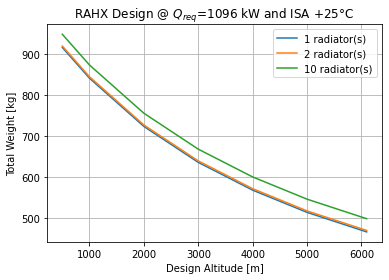

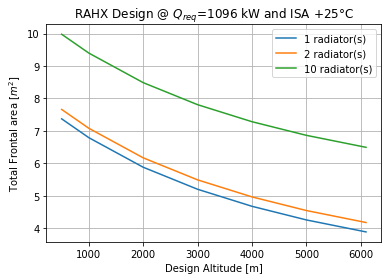

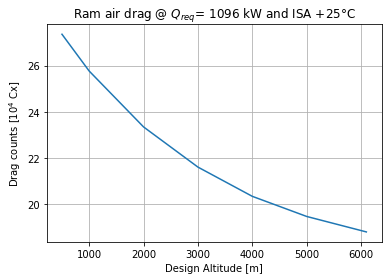

In [10]:
# RADIATORS
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()

for N in N_radiators:
    RA_weights     = []
    RA_front_areas = []
    for i in range(len(Altitude)):
        unit_weight, total_weight, unit_area, total_area = radiator_sizing(Q_req, Altitude[i], Mach[i], Disa, T_load, weight_model, area_model, N)
        RA_weights.append(total_weight)
        RA_front_areas.append(total_area)
    ax1.plot(Altitude,RA_weights,label=str(N) + ' radiator(s)')
    ax2.plot(Altitude,RA_front_areas,label=str(N) + ' radiator(s)')
    

RA_drag_penalty = [] 
for i in range(len(Altitude)):
    airflow, D_RA, Cx, Exergy, A_req = drag_RA(Q_req, Altitude[i], Mach[i], Disa, T_load)
    RA_drag_penalty.append(Cx*1e4)
ax3.plot(Altitude,RA_drag_penalty)
    
ax1.set(xlabel='Design Altitude [m]', ylabel='Total Weight [kg]', title=r'RAHX Design @ $Q_{req}$=' + str(int(Q_req/1000)) + ' kW and ISA +' + str(Disa) + '°C')
ax1.legend()
ax1.grid()
ax2.set(xlabel='Design Altitude [m]', ylabel=r'Total Frontal area [$m^2$]', title=r'RAHX Design @ $Q_{req}$=' + str(int(Q_req/1000)) + ' kW and ISA +' + str(Disa) + '°C')
ax2.legend()
ax2.grid()
ax3.set(xlabel='Design Altitude [m]', ylabel=r'Drag counts [$10^4$ Cx]', title=r'Ram air drag @ $Q_{req}$= ' + str(int(Q_req/1000)) + ' kW and ISA +' + str(Disa) + '°C')
ax3.grid()

## b) SHX performances at different altitudes

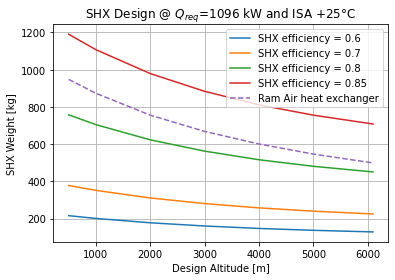

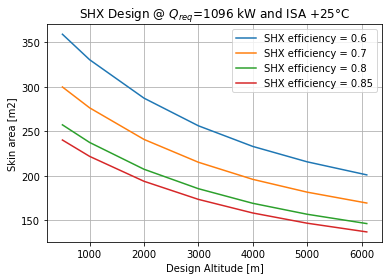

In [11]:
# SKIN HEAT EXCHANGER
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

for eta in eta_SHX:
    SHX_weights = []
    Skin_area   = []
    for i in range(len(Altitude)):
        A_skin, m_SHX = SHX_sizing(Q_req, Altitude[i], Mach[i], Disa, T_load, eta)
        SHX_weights.append(m_SHX)
        Skin_area.append(A_skin)
    ax1.plot(Altitude,SHX_weights,label='SHX efficiency = ' + str(eta))
    ax2.plot(Altitude,Skin_area,label='SHX efficiency = ' + str(eta))


ax1.plot(Altitude,RA_weights,'--',label='Ram Air heat exchanger')
ax1.set(xlabel='Design Altitude [m]', ylabel='SHX Weight [kg]', title=r'SHX Design @ $Q_{req}$=' + str(int(Q_req/1000)) + ' kW and ISA +' + str(Disa) + '°C')
ax1.legend()
ax1.grid()
ax2.set(xlabel='Design Altitude [m]', ylabel='Skin area [m2]', title=r'SHX Design @ $Q_{req}$=' + str(int(Q_req/1000)) + ' kW and ISA +' + str(Disa) + '°C')
ax2.legend()
ax2.grid()

The cooling ability per area improves with the SHX efficiency. On the other hand, higher efficiency results in greater SHX weight.<br>
At low altitudes, the temperature difference between the skin and the air gets smaller, thus decreasing the cooling ability of the SHX.

## c) Airflow rates (Fuel cells + cooling) variation with $\Delta$ISA

**Full ram air coolers configuration, no skin heat exchangers.**<br>
Study @ 1500ft, in different temperature conditions ($\Delta$ ISA)

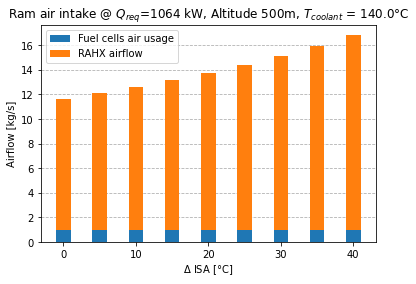

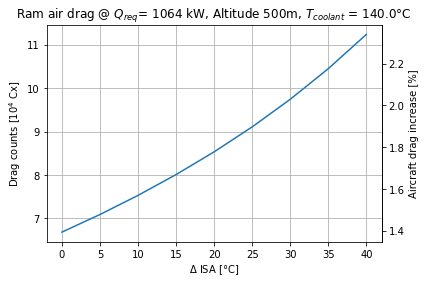

In [12]:
# FC system parameters
System_power = 1800e3 # FC System gross power [W]
T_FC = 273.15 + 150 # fuel cell operating temperature [K]
T_LH2 = 22 # temperature of hydrogen leaving the tank [K]
T_GH2 = T_FC # temperature of hydrogen entering the fuel cells [K]
Q_req = System_power/0.5*0.35 - hydrogen_cooling(System_power, T_LH2, T_GH2) # Cooling requirement [W]

# Operating conditions
Altitude = 500 # [m]
Mach = 0.265
Disa_array = np.arange(0,45,5) # Delta ISA [K]
T_load = T_FC - 10 # coolant temperature [K] 

N_radiators = 1 # number of radiators [-]
drag_aircraft = 480 # aircraft total drag counts [10^4 Cx]    

FC_airflow_array      = []
Cooling_airflow_array = []
Drag_counts_array     = []

for Disa in Disa_array:
    FC_air = 3.57e-7*System_power/0.65
    Cooling_air, D_RA, Cx, Exergy, A_req = drag_RA(Q_req, Altitude, Mach, Disa, T_load)
    
    FC_airflow_array.append(FC_air)
    Cooling_airflow_array.append(Cooling_air)
    Drag_counts_array.append(Cx*1e4)

fig,ax = plt.subplots()
ax.bar(Disa_array, FC_airflow_array, label='Fuel cells air usage', width=2)
ax.bar(Disa_array, Cooling_airflow_array, bottom=FC_airflow_array, label='RAHX airflow', width=2)
ax.set(xlabel=r'$\Delta$ ISA [°C]',ylabel='Airflow [kg/s]', title=r'Ram air intake @ $Q_{req}$=' + str(int(Q_req/1000)) + ' kW, Altitude ' + str(Altitude) + r'm, $T_{coolant}$ = ' + str(T_load - 273.15) + '°C')
#plt.axhline(y=Q_req/1000,linewidth=1, color='gray', linestyle='--')
ax.grid(axis='y',ls='--')
ax.set_axisbelow(True)
ax.legend()


fig2,ax2 = plt.subplots()
secaxy = ax2.secondary_yaxis('right', functions=(lambda x : x/drag_aircraft*100, lambda x : x*drag_aircraft/100))
secaxy.set_ylabel('Aircraft drag increase [%]')
ax2.plot(Disa_array, Drag_counts_array)
ax2.set(xlabel=r'$\Delta$ ISA [°C]', ylabel=r'Drag counts [$10^4$ Cx]', title=r'Ram air drag @ $Q_{req}$= ' + str(int(Q_req/1000)) + ' kW, Altitude ' +str(Altitude) + r'm, $T_{coolant}$ = ' + str(T_load - 273.15) + '°C')
ax2.grid()

-----------------

# 4 - Optimization under constraints

An optimization algorithm is implemented in order to find the architecture that minimizes the weight of the heat rejection system. The objective function is defined as

$$ f(x) = m_{RAHX}(x) + m_{SHX}(1-x) $$

Where $x$ represents the share of heat rejected by the ram air heat exchanger: $x = Q_{RAHX} / Q_{req}.$<br>
The minimization is subject to the constraint of the available wetted area available for the skin heat exchanger, and the max. frontal area of the radiators. Thus, the optimization problem is

$$ \text{minimize } f(x) \text{ subject to } c_1(x),c_2(x) \geq 0$$ 
$$ c_1(x) = A^{max}_{SHX} - A_{SHX}(1-x)$$
$$ c_2(x) = A^{max}_{RAHX} - A_{RAHX}(x)$$

The wetted areas of the ATR-72 are given below:

| Designation | Wetted area [$m^2$] |
| --- | --- |
| Fuselage | 160.859|
| Wing |113.075|
|Horizontal tail| 22.829|
|Vertical tail|24.423|
|Dorsal fin|6.811|
|Engine nacelles|22.268|
|Landing gear fairing| 31.138(\*)|
|Wing/Body fairing|11.308|
|Flap hinge fairing|6.37|


(\*) subject to modifications for hybrid ATR

In addition, the cross section area of the bellyfairing is estimated to **2 m$^2$**.

In [13]:
# OBJECTIVE FUNCTION: mass minimization (x: Radiators heat rejection / total heat rejection)
def objective(x, Q_req, Altitude, Mach, Disa, T_load, eta_SHX, N_radiators):
    Q_RA = x*Q_req # Heat rejected by radiators
    Q_SHX = (1-x)*Q_req # Heat rejected by skin exchangers
    
    # Radiator design
    m_RA_unit, m_RA, A_RA_unit, A_RA = radiator_sizing(Q_RA, Altitude, Mach, Disa, T_load, weight_model, area_model, N_radiators)
    
    # SHX design parameters
    A_skin, m_SHX = SHX_sizing(Q_SHX, Altitude, Mach, Disa, T_load, eta_SHX)

    M = m_RA + m_SHX
    return M
    
# CONSTRAINT: available skin area
A_SKIN_AVAILABLE = 90 # [m2]
def skin_area_constraint(x, Q_req, Altitude, Mach, Disa, T_load, eta_SHX, _):
    A_skin, _ = SHX_sizing((1-x)*Q_req, Altitude, Mach, Disa, T_load, eta_SHX)
    return (A_SKIN_AVAILABLE - A_skin)

# CONSTRAINT: available cross-sectional area in bellyfairing
A_BELLY_AVAILABLE = 4.01 # [m2]  4m2 = 2 rows of radiators in the bellyfairing
def belly_cross_area_constraint(x, Q_req, Altitude, Mach, Disa, T_load, _, N_radiators):
    _,_,_,A_RA = radiator_sizing(x*Q_req, Altitude, Mach, Disa, T_load, weight_model, area_model, N_radiators)
    return (A_BELLY_AVAILABLE - A_RA)

## a) Weight variation with design SHX efficiency

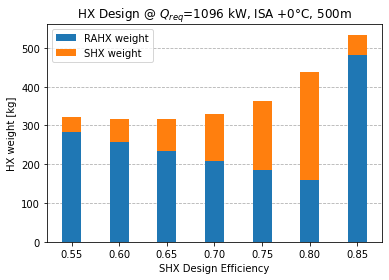

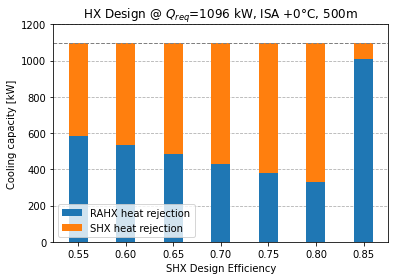

In [14]:
# FC system parameters
System_power = 1800e3 # FC System gross power [W]
T_FC = 273.15 + 80 # fuel cell operating temperature [K]
T_LH2 = 22 # temperature of hydrogen leaving the tank [K]
T_GH2 = T_FC # temperature of hydrogen entering the fuel cells [K]
Q_req = System_power/0.5*0.35 - hydrogen_cooling(System_power, T_LH2, T_GH2) # Cooling requirement [W]

# Operating conditions
Altitude = 500 # [m]
Mach = 0.265 # [-]
Disa = 0 # Delta ISA [K]
T_load = 273.15 + 75 # coolant temperature [K] 

N_radiators = 1 # number of radiators [-]
eta_SHX_array = np.arange(0.55, 0.9, 0.05) # SHX heat transfer efficiency [-]

SHX_mass_array   = []
RA_mass_array    = []
SHX_area_array   = []
RA_area_array    = []
Q_SHX_array      = []
Q_RA_array       = []


#############################
for eta_SHX in eta_SHX_array:  
    # fixed parameters
    fixed_arguments=(Q_req, Altitude, Mach, Disa, T_load, eta_SHX, N_radiators)
    
    # constraints
    cons = []
    cons_SHX={"fun": skin_area_constraint, "type": "ineq", "args":fixed_arguments}
    cons_RA={"fun": belly_cross_area_constraint, "type": "ineq", "args":fixed_arguments}
    lower, upper = [0,1]
    l = {'type': 'ineq',
         'fun': lambda x, lb=lower: x - lb}
    u = {'type': 'ineq',
         'fun': lambda x, ub=upper: ub - x}
    cons.append(cons_RA)
    cons.append(cons_SHX)
    cons.append(l)
    cons.append(u)
    
    # initial guess
    x0=np.array([0.5])
    
    # optimization
    result = optimize.minimize(objective, x0, args=fixed_arguments,method="COBYLA",
                         constraints=cons)
    #print(result)
    if result.success == False:
        print('Optimization failed for eta_SHX=',eta_SHX, '- Did not converge to a solution satisfying the constraints.')
        m_RA, m_SHX, A_RA, A_SHX, Q_RA, Q_SHX = (0,0,0,0,0,0)
    else:
        x = result.x[0]
        _,m_RA,_,A_RA = radiator_sizing(x*Q_req, Altitude, Mach, Disa, T_load, weight_model, area_model, N_radiators)
        A_SHX,m_SHX = SHX_sizing((1-x)*Q_req, Altitude, Mach, Disa, T_load, eta_SHX)
        Q_RA = x*Q_req/1000
        Q_SHX = (1-x)*Q_req/1000
    
    # Plots
    SHX_mass_array.append(m_SHX)
    RA_mass_array.append(m_RA)
    SHX_area_array.append(A_SHX)
    RA_area_array.append(A_RA)
    Q_RA_array.append(Q_RA)
    Q_SHX_array.append(Q_SHX)
    

fig,ax = plt.subplots()
ax.bar(eta_SHX_array, RA_mass_array, label='RAHX weight', width=0.02)
ax.bar(eta_SHX_array, SHX_mass_array, bottom=RA_mass_array, label='SHX weight', width=0.02)
ax.set(xlabel='SHX Design Efficiency', ylabel='HX weight [kg]', title=r'HX Design @ $Q_{req}$=' + str(int(Q_req/1000)) + ' kW, ISA +' + str(Disa) + '°C, ' + str(Altitude) + 'm')
ax.grid(axis='y',ls='--')
ax.set_axisbelow(True)
ax.legend()

fig,ax = plt.subplots()
ax.bar(eta_SHX_array, Q_RA_array, label='RAHX heat rejection', width=0.02)
ax.bar(eta_SHX_array, Q_SHX_array, bottom=Q_RA_array, label='SHX heat rejection', width=0.02)
plt.axhline(y=Q_req/1000,linewidth=1, color='gray', linestyle='--')
ax.set(xlabel='SHX Design Efficiency',ylabel='Cooling capacity [kW]',yticks=np.arange(0,Q_req/1000+200,200), title=r'HX Design @ $Q_{req}$=' + str(int(Q_req/1000)) + ' kW, ISA +' + str(Disa) + '°C, ' + str(Altitude) + 'm')
ax.grid(axis='y',ls='--')
ax.set_axisbelow(True)
ax.legend()

For efficiencies below 80%, skin heat exchangers are lighter than ram air heat exchangers. Thus, the whole skin surface available is used for heat rejection. However, when the efficiency gets higher than 80%, skin heat exchangers are heavier than ram air heat exchangers, and ram air cooling is prefered over skin cooling.

## b) Weight variation with design altitude
The SHX efficiency is kept around its optimal value: $\eta_{SHX}=0.7$.

Optimization failed for Altitude= 4000 - Did not converge to a solution satisfying the constraints.


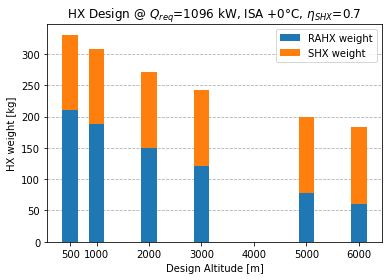

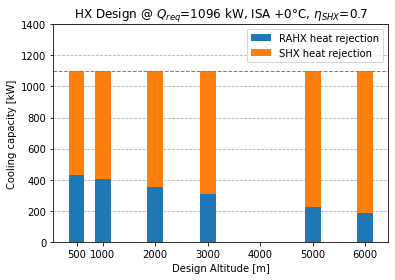

In [15]:
# FC system parameters
System_power = 1800e3 # FC System gross power [W]
T_FC = 273.15 + 80 # fuel cell operating temperature [K]
T_LH2 = 22 # temperature of hydrogen leaving the tank [K]
T_GH2 = T_FC # temperature of hydrogen entering the fuel cells [K]
Q_req = System_power/0.5*0.35 - hydrogen_cooling(System_power, T_LH2, T_GH2) # Cooling requirement [W]

# Operating conditions
Altitude_array = [500, 1000, 2000, 3000, 4000, 5000, 6000]
Mach_array = [0.265, 0.273, 0.290, 0.309, 0.330, 0.352, 0.379]
Disa = 0 # Delta ISA [K]
T_load = 273 + 75 # coolant temperature [K] 

N_radiators = 1 # number of radiators [-]
eta_SHX = 0.7 # SHX heat transfer efficiency [-]

Q_SHX_array      = []
Q_RA_array       = []
SHX_mass_array   = []
RA_mass_array    = []

#############################
for i in range(len(Altitude_array)): 
    # fixed parameters
    Altitude = Altitude_array[i]
    Mach = Mach_array[i]
    fixed_arguments=(Q_req, Altitude, Mach, Disa, T_load, eta_SHX, N_radiators)

    # constraints
    cons = []
    cons_SHX={"fun": skin_area_constraint, "type": "ineq", "args":fixed_arguments}
    cons_RA={"fun": belly_cross_area_constraint, "type": "ineq", "args":fixed_arguments}
    lower, upper = [0,1]
    l = {'type': 'ineq',
         'fun': lambda x, lb=lower: x - lb}
    u = {'type': 'ineq',
         'fun': lambda x, ub=upper: ub - x}
    cons.append(cons_RA)
    cons.append(cons_SHX)
    cons.append(l)
    cons.append(u)
    
    # initial guess
    x0=np.array([0.5])
    
    # optimization
    result = optimize.minimize(objective, x0, args=fixed_arguments,method="COBYLA",
                         constraints=cons)
    #print(result)
    if result.success == False:
        print('Optimization failed for Altitude=',Altitude, '- Did not converge to a solution satisfying the constraints.')
        m_RA, m_SHX, Q_RA, Q_SHX = (0,0,0,0)
    else:
        x = result.x[0]
        _,m_RA,_,_ = radiator_sizing(x*Q_req, Altitude, Mach, Disa, T_load, weight_model, area_model, N_radiators)
        _,m_SHX = SHX_sizing((1-x)*Q_req, Altitude, Mach, Disa, T_load, eta_SHX)
        Q_RA = x*Q_req/1000
        Q_SHX = (1-x)*Q_req/1000
    
    # Plots
    Q_RA_array.append(Q_RA)
    Q_SHX_array.append(Q_SHX)
    SHX_mass_array.append(m_SHX)
    RA_mass_array.append(m_RA)

fig,ax = plt.subplots()
ax.bar(Altitude_array, RA_mass_array, label='RAHX weight', width=300)
ax.bar(Altitude_array, SHX_mass_array, bottom=RA_mass_array, label='SHX weight', width=300)
ax.set(xlabel='Design Altitude [m]', xticks=Altitude_array, ylabel='HX weight [kg]', title=r'HX Design @ $Q_{req}$=' + str(int(Q_req/1000)) + ' kW, ISA +' + str(Disa) + '°C, ' + r'$\eta_{SHX}$=' + str(eta_SHX))
ax.grid(axis='y',ls='--')
ax.set_axisbelow(True)
ax.legend()

fig,ax = plt.subplots()
ax.bar(Altitude_array, Q_RA_array, label='RAHX heat rejection', width=300)
ax.bar(Altitude_array, Q_SHX_array, bottom=Q_RA_array, label='SHX heat rejection', width=300)
ax.set(xlabel='Design Altitude [m]', xticks=Altitude_array, yticks=np.arange(0,Q_req/1000+400,200),ylabel='Cooling capacity [kW]', title=r'HX Design @ $Q_{req}$=' + str(int(Q_req/1000)) + ' kW, ISA +' + str(Disa) + '°C, ' + r'$\eta_{SHX}$=' + str(eta_SHX))
plt.axhline(y=Q_req/1000,linewidth=1, color='gray', linestyle='--')
ax.grid(axis='y',ls='--')
ax.set_axisbelow(True)
ax.legend()

## c) Weight and airflow variations with $\Delta$ISA
* The SHX efficiency is kept around 70%: $\eta_{SHX}=0.7$.
* The design altitude is 500m : initial climb.

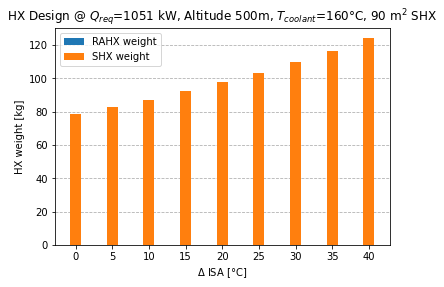

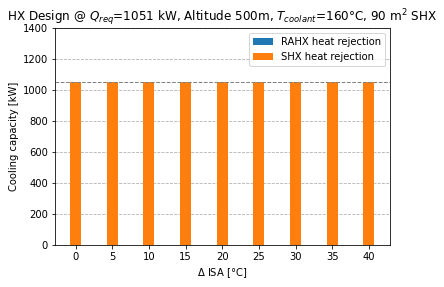

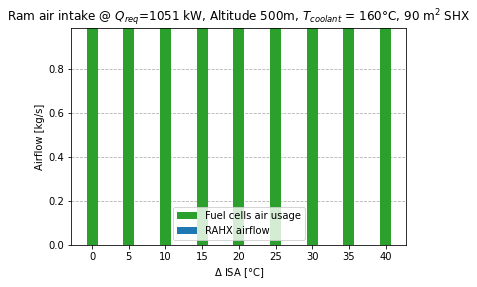

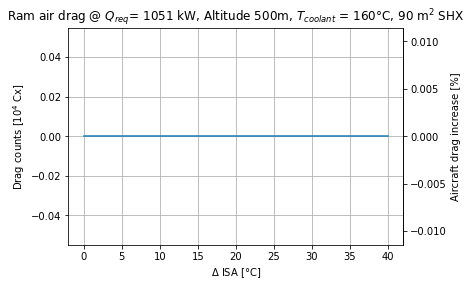

In [16]:
# FC system parameters
System_power = 1800e3 # FC System gross power [W]
T_FC = 273 + 180 # fuel cell operating temperature [K]
T_LH2 = 22 # temperature of hydrogen leaving the tank [K]
T_GH2 = T_FC # temperature of hydrogen entering the fuel cells [K]
Q_req = System_power/0.5*0.35 - hydrogen_cooling(System_power, T_LH2, T_GH2) # Cooling requirement [W]

# Operating conditions
Altitude = 500 # [m]
Mach = 0.265
Disa_array = np.arange(0,45,5) #np.array([0,5,10,15,18,20,25]) # Delta ISA [K]
T_load = 273 + 160 #T_FC - 5 # coolant temperature [K] 

N_radiators = 1 # number of radiators [-]
eta_SHX = 0.7 # SHX heat transfer efficiency [-]

Q_SHX_array      = []
Q_RA_array       = []
SHX_mass_array   = []
RA_mass_array    = []
SHX_area_array   = []
RA_area_array    = []
FC_airflow_array      = []
A_req_array           = []
Cooling_airflow_array = []
Drag_counts_array     = []


#############################
for Disa in Disa_array: 
    # fixed parameters
    fixed_arguments=(Q_req, Altitude, Mach, Disa, T_load, eta_SHX, N_radiators)

    # constraints
    cons = []
    cons_SHX={"fun": skin_area_constraint, "type": "ineq", "args":fixed_arguments}
    cons_RA={"fun": belly_cross_area_constraint, "type": "ineq", "args":fixed_arguments}
    lower, upper = [0,1]
    l = {'type': 'ineq',
         'fun': lambda x, lb=lower: x - lb}
    u = {'type': 'ineq',
         'fun': lambda x, ub=upper: ub - x}
    cons.append(cons_RA)
    cons.append(cons_SHX)
    cons.append(l)
    cons.append(u)
    
    # initial guess
    x0=np.array([0.51])
    
    # optimization
    result = optimize.minimize(objective, x0, args=fixed_arguments,method="COBYLA",
                         constraints=cons)
    
    if result.success == False:
        print('Optimization failed for ISA +',Disa, '°C - Did not converge to a solution satisfying the constraints.')
        m_RA, m_SHX, A_RA, A_SHX, Q_RA, Q_SHX = (0,0,0,0,0,0)
        FC_air,Cooling_air, D_RA, Cx, Exergy = (np.nan,np.nan,np.nan,np.nan,np.nan)
    else:
        x = result.x[0]
        _,m_RA,_,A_RA = radiator_sizing(x*Q_req, Altitude, Mach, Disa, T_load, weight_model, area_model, N_radiators)
        A_SHX,m_SHX = SHX_sizing((1-x)*Q_req, Altitude, Mach, Disa, T_load, eta_SHX)
        Q_RA = x*Q_req/1000
        Q_SHX = (1-x)*Q_req/1000
         
        # Air usage and drag
        FC_air = 3.57e-7*System_power/0.65
        Cooling_air, D_RA, Cx, Exergy, A_req = drag_RA(x*Q_req, Altitude, Mach, Disa, T_load)
    
    # Plots
    Q_RA_array.append(Q_RA)
    Q_SHX_array.append(Q_SHX)
    if Q_SHX == 0:
        m_SHX = 0
    if Q_RA == 0:
        m_RA = 0
    SHX_mass_array.append(m_SHX)
    RA_mass_array.append(m_RA)
    SHX_area_array.append(A_SHX)
    RA_area_array.append(A_RA)
    FC_airflow_array.append(FC_air)
    A_req_array.append(A_req)
    Cooling_airflow_array.append(Cooling_air)
    Drag_counts_array.append(Cx*1e4)

################    
bar_width = 1.5
    
fig,ax = plt.subplots()
ax.bar(Disa_array, RA_mass_array, label='RAHX weight', width=bar_width)
ax.bar(Disa_array, SHX_mass_array, bottom=RA_mass_array, label='SHX weight', width=bar_width)
ax.set(xlabel=r'$\Delta$ ISA [°C]', xticks=Disa_array, ylabel='HX weight [kg]', title=r'HX Design @ $Q_{req}$=' + str(int(Q_req/1000)) + ' kW, Altitude ' + str(Altitude) + 'm, ' + r'$T_{coolant}$=' + str(T_load-273)+'°C, ' + str(A_SKIN_AVAILABLE) + r' m$^2$ SHX')
ax.grid(axis='y',ls='--')
ax.set_axisbelow(True)
ax.legend()

fig,ax = plt.subplots()
ax.bar(Disa_array, Q_RA_array, label='RAHX heat rejection', width=bar_width)
ax.bar(Disa_array, Q_SHX_array, bottom=Q_RA_array, label='SHX heat rejection', width=bar_width)
ax.set(xlabel=r'$\Delta$ ISA [°C]', xticks=Disa_array, yticks=np.arange(0,Q_req/1000+400,200),ylabel='Cooling capacity [kW]', title=r'HX Design @ $Q_{req}$=' + str(int(Q_req/1000)) + ' kW, Altitude ' + str(Altitude) + 'm, ' + r'$T_{coolant}$=' + str(T_load-273)+'°C, ' + str(A_SKIN_AVAILABLE) + r' m$^2$ SHX')
plt.axhline(y=Q_req/1000,linewidth=1, color='gray', linestyle='--')
ax.grid(axis='y',ls='--')
ax.set_axisbelow(True)
ax.legend()

fig,ax = plt.subplots()
ax.bar(Disa_array, FC_airflow_array, label='Fuel cells air usage', width=bar_width, color='tab:green')
ax.bar(Disa_array, Cooling_airflow_array, bottom=FC_airflow_array, label='RAHX airflow', width=bar_width)
ax.set(xticks=Disa_array,xlabel=r'$\Delta$ ISA [°C]',ylabel='Airflow [kg/s]', title=r'Ram air intake @ $Q_{req}$=' + str(int(Q_req/1000)) + ' kW, Altitude ' + str(Altitude) + r'm, $T_{coolant}$ = ' + str(T_load - 273) + '°C, ' + str(A_SKIN_AVAILABLE) + r' m$^2$ SHX')
#plt.axhline(y=Q_req/1000,linewidth=1, color='gray', linestyle='--')
ax.grid(axis='y',ls='--')
ax.set_axisbelow(True)
ax.legend()

fig,ax = plt.subplots()
secaxy = ax.secondary_yaxis('right', functions=(lambda x : x/drag_aircraft*100, lambda x : x*drag_aircraft/100))
secaxy.set_ylabel('Aircraft drag increase [%]')
ax.plot(Disa_array, Drag_counts_array)
ax.set(xticks=Disa_array,xlabel=r'$\Delta$ ISA [°C]', ylabel=r'Drag counts [$10^4$ Cx]', title=r'Ram air drag @ $Q_{req}$= ' + str(int(Q_req/1000)) + ' kW, Altitude ' +str(Altitude) + r'm, $T_{coolant}$ = ' + str(T_load - 273) + '°C, ' + str(A_SKIN_AVAILABLE) + r' m$^2$ SHX')
ax.grid()